# Setup

In [1]:
# import your standard packages
%run ../../../global_tools/start.py

# import your local functions
sys.path.insert(1, '../')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Parameters and Paths

In [2]:
outfn = '../../data/sla_processed.nc'

# get data from tigress
inpath = '/home/jennap/projects/LRGROUP/shared_data/ssh-CCCS/concatenated/'
infn = 'all_dt_global_twosat_phy_l4__vDT2018_19930101_to_20200603.nc'

lat_bounds = [-1.5, 33]
lon_bounds = [48.5, 102.5]
time_bounds = ['1993-01-01','2020-05-31']

# Get Data and Subset

In [3]:
ds = xr.open_dataset(inpath + infn)

# Subset ------------------------------------------------#
lat_slice = slice(lat_bounds[0], lat_bounds[1])
lon_slice = slice(lon_bounds[0], lon_bounds[1])
time_slice = slice(time_bounds[0],time_bounds[1])

ds = ds.sel(lat=lat_slice,lon=lon_slice, time = time_slice)

# Get data, selecting lat/lon slice
daily_sla = ds['sla'].sel(lat=lat_slice,lon=lon_slice, time = time_slice)
lat = daily_sla.lat.values
lon = daily_sla.lon.values
ds

<xarray.Dataset>
Dimensions:  (lat: 138, lon: 216, time: 10013)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-05-31
  * lat      (lat) float32 -1.375 -1.125 -0.875 -0.625 ... 32.375 32.625 32.875
  * lon      (lon) float32 48.625 48.875 49.125 ... 101.875 102.125 102.375
Data variables:
    sla      (time, lat, lon) float64 ...
Attributes:
    date_created:               01/21/2021
    unmerged_data_url:          https://cds.climate.copernicus.eu/cdsapp#!/da...
    geospatial_lat_units:       decimal degrees north (-90,90)
    geospatial_lon_units:       decimal degrees east (0,360)
    geospatial_lat_resolution:  0.25
    geospatial_lon_resolution:  0.25
    sensors:                    The reference mission used for the altimeter ...
    product_version:            vJul2020
    processing_level:           L4
    software_version:           6.4_DUACS_DT2018_baseline
    platform:                   Jason-3, Sentinel-3A
    history:                    Mer

# Detrend SLA

Resources: [link](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Example_calculations_with_scalar_quantities.html), [link](https://groups.google.com/g/xarray/c/fz7HHgpgwk0), [link](https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values), [link](https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values), [link](https://stackoverflow.com/questions/17638137/curve-fitting-to-a-time-series-in-the-format-datetime)



In [4]:
%%time

# stack lat and lon into a single dimension called allpoints
stacked = daily_sla.stack(allpoints=['lat','lon'])

# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
daily_sla_slope, daily_sla_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
daily_sla_slope = np.reshape(daily_sla_slope, daily_sla.shape[1:3])
daily_sla_intercept = np.reshape(daily_sla_intercept, daily_sla.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
daily_sla_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
daily_sla_dtrnd = daily_sla_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
daily_sla_dtrnd = daily_sla_dtrnd.where(~np.isnan(daily_sla))

CPU times: user 1h 1min 41s, sys: 2min 38s, total: 1h 4min 20s
Wall time: 4min 36s


/home/jennap/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Time')

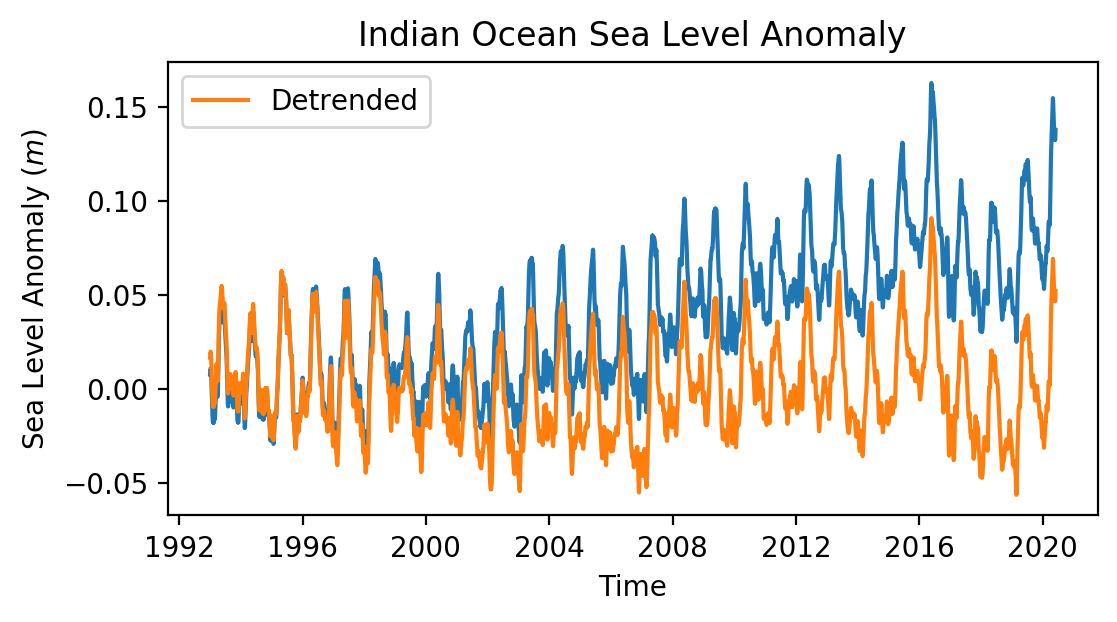

In [5]:
# find global means for comparison
stacked = daily_sla.stack(allpoints=['lat','lon'])
global_mean = stacked.mean(dim='allpoints',skipna=True)
# global_mean.plot()

# find global means for comparison 
stacked = daily_sla_dtrnd.stack(allpoints=['lat','lon'])
global_mean_dtrnd = stacked.mean(dim='allpoints',skipna=True)
# global_mean_dtrnd.plot()
# plt.legend


fig = plt.figure(figsize=(6,3),dpi=200)
plt.plot(global_mean.time,global_mean)
plt.plot(global_mean_dtrnd.time,global_mean_dtrnd, label = 'Detrended')
plt.legend()
plt.title('Indian Ocean Sea Level Anomaly')
plt.ylabel('Sea Level Anomaly ($m$)')
plt.xlabel('Time')

# Downsample to Monthly and Seasonal Temporal Resolution

In [6]:
# monthly
mon_sla_dtrnd = daily_sla_dtrnd.resample(time='1MS').mean(dim="time")

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Find Monthly Climatology and Anomaly
Resources: [link](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

In [7]:
# monthly clim
mon_sla_mon_clim_dtrnd = monthly_clim(daily_sla_dtrnd)

# monthly anom = monthly avg data - monthly climatology
mon_sla_mon_anom_dtrnd = mon_sla_dtrnd.groupby('time.month') - mon_sla_mon_clim_dtrnd


# Find Coastlines

Text(0.5, 1.0, 'Unordered Stations')

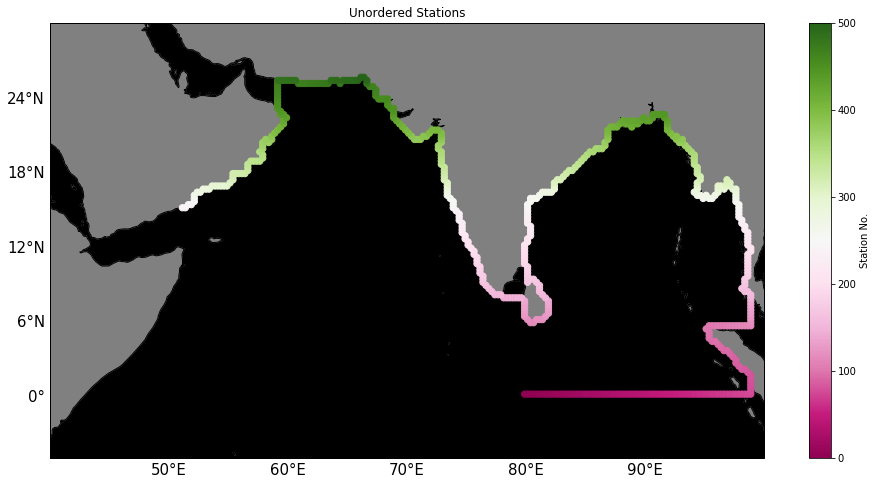

In [27]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = mon_sla_dtrnd[0,:,:]
lat = daily_sla.lat.values
lon = daily_sla.lon.values
xx,yy = np.meshgrid(lon,lat)
# set Gulfs to Nans
mask = mask.where(~((yy>22) & (xx<59)))
mask = mask.where(~((yy>10) & (xx<51)))

# AS inlets
mask = mask.where(~((yy>21.5) & (yy<23) & (xx>72) & (xx<73)))
mask = mask.where(~((yy>22.25) & (yy<23) & (xx>69) & (xx<70.5)))
mask = mask.where(~((yy>23.25) & (yy<24) & (xx>68.5) & (xx<70)))

# sri lanka are
mask = mask.where(~((yy>8) & (yy<10.5) & (xx>78) & (xx<80)))

# Sumatra area
mask = mask.where(~((yy>4.5) & (yy<5.5) & (xx>95.5) & (xx<100)))
mask = mask.where(~((yy>3) & (yy<5.5) & (xx>97.5) & (xx<100)))
mask = mask.where(~((yy>0) & (yy<10) & (xx>99) & (xx<100)))
mask = mask.where(~((yy>0) & (yy<2.5) & (xx>97) & (xx<98)),1)

# equator
mask = mask.where(~(yy<0))
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
#         cond = (~np.isnan(arr[row,col])) & (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),max(0,col-1):min(arr.shape[1],col+2)])))
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

#         if  (~np.isnan(arr[row,col])) & cond):
        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))
# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

# sta_latinds_unord = sta_latinds_unord[46:]
# sta_loninds_unord = sta_loninds_unord[46:]

sta_latinds_unord = sta_latinds_unord[125:]
sta_loninds_unord = sta_loninds_unord[125:]

# AS
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

#BoB
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~(lons_from_sta >99)
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

bounds = [40,100,-5,30]

def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
plt.scatter(lon[sta_loninds_unord],lat[sta_latinds_unord],
            s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
plt.colorbar(label = 'Station No.')
plt.title('Unordered Stations')

No Next Station Found. Returning Previous Stations Only.
(10, 66) [(201, 28), (201, 6), (126, 43), (126, 42), (43, 96)]
lons:  [79.875 98.625 87.125 78.875 66.125 51.125]
lats:  [ 0.125  0.125 21.625  7.875 25.625 15.125]


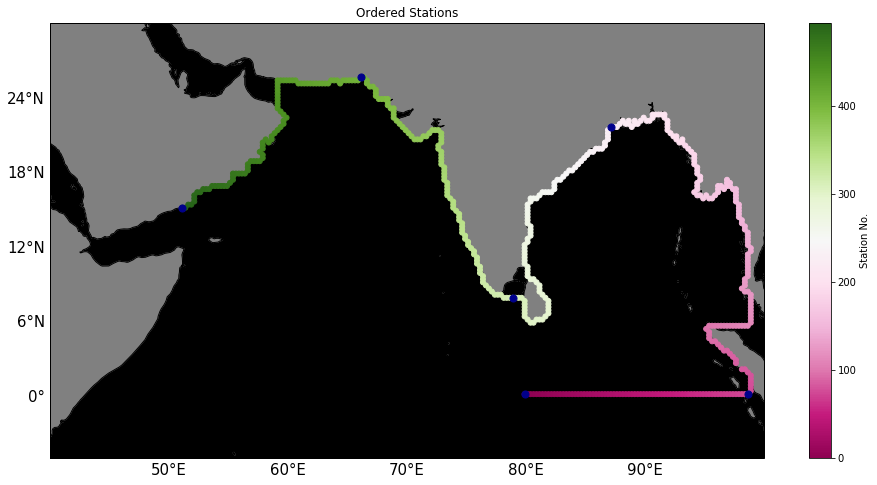

In [28]:
# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#


def order_coast(loninds,latinds,sta_zero):
    # find based on radius
    zipped_lists = zip(loninds, latinds)
    sorted_pairs = sorted(zipped_lists, reverse=True)

    # sort by lon
    tuples = zip(*sorted_pairs)
    lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

    pos = []
    curr_sta = []
    rem_sta = sorted_pairs
    for i in range(len(lon_list)):
#         print(i)
        if i == 0:
            curr_sta.append(sta_zero)
            rem_sta.remove(sta_zero) 
            prev_sta = sta_zero
        else:
            prev_sta = curr_sta[i-1]

        start_len = len(curr_sta)
        for j,(lo, la) in enumerate(rem_sta):
            next_sta = (rem_sta[j])
            
            diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
            
            # check uplr first
            if(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break

            # then check diagonals
            elif (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break
                
        if len(curr_sta) == start_len:
            print('No Next Station Found. Returning Previous Stations Only.')
            print(curr_sta[i],rem_sta)
            break
        
    sta_lonind, sta_latind  = map(np.array, zip(*curr_sta))
    
    return sta_lonind, sta_latind

#initial station
sta_zero = (sta_loninds_unord[0],sta_latinds_unord[0]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

# remove the one weird nan - use next code block to help identify it
sta_loninds = np.delete(sta_loninds,85)
sta_latinds = np.delete(sta_latinds,85)

# cut off extra arabian sea
sta_latinds = sta_latinds
sta_loninds = sta_loninds


# ------------------------------------------------------------#
# identify first stations for EQ, BOB, and AS
# ------------------------------------------------------------#
# old country based ones
# JA = 0
# sBoB = 120
# mBoB = 210
# SL = 300
# mAS = 410
# eAS = 494
# loc_list = [JA,sBoB,mBoB,SL,mAS,eAS]

JA = 0
sEBoB = 75
sWBoB = 225
sEAS = 313
sWAS = 406
eWAS = 494

loc_list = [JA,sEBoB,sWBoB,sEAS,sWAS,eWAS]


# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
bounds = [40,100,-5,30]

def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)

p =plt.scatter(lon[sta_loninds],lat[sta_latinds],
            s = 100,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG) 
plt.scatter(lon[sta_loninds[loc_list]],lat[sta_latinds[loc_list]],
            s = 200,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')
plt.title('Ordered Stations')

print('lons: ',lon[sta_loninds[loc_list]])
print('lats: ',lat[sta_latinds[loc_list]])

In [29]:
len(sta_loninds)

495

In [30]:
# use this to find the random nan value that appeasr someotimes

data = np.zeros([12,sta_loninds.shape[0]])

for jj in range(sta_loninds.shape[0]):
        data[:,jj] = mon_sla_dtrnd[0,sta_latinds[jj],sta_loninds[jj]]
        
np.argwhere(np.isnan(data))

array([], shape=(0, 2), dtype=int64)

# Save Data

In [31]:
# convert to xarray dataset
ds_out = xr.Dataset(coords={'lon': mon_sla_dtrnd.lon,
                    'lat': mon_sla_dtrnd.lat,
                    'time': mon_sla_dtrnd.time})

# add variables to dataset
ds_out["daily_sla"]=xr.DataArray(daily_sla_dtrnd,dims = ['day_time','lat', 'lon'],
                     coords =[daily_sla_dtrnd.time,daily_sla_dtrnd.lat,daily_sla_dtrnd.lon])

ds_out["mon_sla"]=xr.DataArray(mon_sla_dtrnd,dims = ['time','lat', 'lon'],
                     coords =[mon_sla_dtrnd.time,daily_sla_dtrnd.lat,daily_sla_dtrnd.lon])

# clim
ds_out["mon_sla_mon_clim"]=xr.DataArray(mon_sla_mon_clim_dtrnd,dims = ['month','lat', 'lon'],
                     coords =[mon_sla_mon_clim_dtrnd.month,daily_sla_dtrnd.lat,daily_sla_dtrnd.lon])

# anom
ds_out["mon_sla_mon_anom"]=xr.DataArray(mon_sla_mon_anom_dtrnd,dims = ['time','lat', 'lon'],
                   coords =[mon_sla_mon_anom_dtrnd.time,daily_sla_dtrnd.lat,daily_sla_dtrnd.lon])

no_stations =np.linspace(1,len(sta_loninds),len(sta_loninds))

ds_out['sta_loninds'] = xr.DataArray(sta_loninds,dims = ['no_stations'],coords =[no_stations])
ds_out['sta_latinds'] = xr.DataArray(sta_latinds,dims = ['no_stations'],coords =[no_stations])
ds_out['loc_list'] = xr.DataArray(loc_list,dims = ['loc_list'],coords =[loc_list])

ds_out['sta_lon'] = xr.DataArray(lon[sta_loninds],dims = ['no_stations'],coords =[no_stations])
ds_out['sta_lat'] = xr.DataArray(lat[sta_latinds],dims = ['no_stations'],coords =[no_stations])
ds_out['loc_list'] = xr.DataArray(loc_list,dims = ['loc_list'],coords =[loc_list])



# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds_out

<xarray.Dataset>
Dimensions:           (day_time: 10013, lat: 138, loc_list: 6, lon: 216, month: 12, no_stations: 495, time: 329)
Coordinates:
  * lon               (lon) float64 48.62 48.88 49.12 ... 101.9 102.1 102.4
  * lat               (lat) float64 -1.375 -1.125 -0.875 ... 32.38 32.62 32.88
  * time              (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2020-05-01
  * day_time          (day_time) datetime64[ns] 1993-01-01 ... 2020-05-31
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * no_stations       (no_stations) float64 1.0 2.0 3.0 ... 493.0 494.0 495.0
  * loc_list          (loc_list) int64 0 75 225 313 406 494
Data variables:
    daily_sla         (day_time, lat, lon) float64 -0.08236 -0.08397 ... nan nan
    mon_sla           (time, lat, lon) float64 -0.006239 -0.007742 ... nan nan
    mon_sla_mon_clim  (month, lat, lon) float64 -0.04307 -0.04316 ... nan nan
    mon_sla_mon_anom  (time, lat, lon) float64 0.03683 0.03542 ... nan nan
    sta_loninds  